-----------
Notebook inspired by Hans Rosling's presentation "The best stats you\'ve ever seen"(https://www.ted.com/talks/hans_rosling_the_best_stats_you_ve_ever_seen). I wrote it to explore Gapminder without using their excellent tool, while being enrolled in Coursera\'s Introduction to Data Science with Python: part IV Plotting. 

__TOC of this notebook__
- Animation showing the change of demographic and economic variables over time
- Interactive info-plot with annotations (country stats)

The script uses external datafiles that have been downloaded from Gapminder (as of Nov 2021), and are publicly available on my GitHub account. 

__List of external files__
- income_per_person_gdppercapita_ppp_inflation_adjusted.csv
- life_expectancy_years.csv
- population_total.csv
- children_per_woman_total_fertility.csv
- ountries_per_continent.csv - used for indexing - downloaded and adapted in Nov 2021 from 
https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent

-----------


# Tradeoff between life-expectancy and fertility 

Overpopulation of the planet is arguably one of the critical issues that affects our future. There have never been more people on earth than right now, and they keep multiplying. They also live longer ... but this may actually be good - if one ignores the issue of ageing societies - because life expectancy is negatively associated with fertility. 

When people live longer they have fewer children. At least this is what we see in western industrialised countries. Also in Arab countries and parts of Asia. In Africa, however, life is short and people have many children. __Run the cells below to illustrate the association between life expectancy and birth rate in a graph__.   


In [6]:
# Execute this cell to import libraries, define basic functions and load data into DataFrames 
import pandas as pd
import numpy as np
import re
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

# COUNTRY / CONTINENT cList
def importCLIST(): 
    fn = r'https://raw.github.com/tkatus/data/main/countries_per_continent.csv'
    cList = pd.read_csv(fn)
    cList.columns = ['continent', 'country']
    d = {'Congo, Democratic Republic of': 'Congo, Dem. Rep.', 'Burkina': 'Burkina Faso', 'Burma (Myanmar)': 'Myanmar', 'Korea, North': 'North Korea', 'Korea, South': 'South Korea', 'Kyrgyzstan': 'Kyrgyz Republic', 'Russian Federation': 'Russia', 'CZ': 'Czech Republic', 'Macedonia': 'North Macedonia', 'Saint Kitts and Nevis': 'St. Kitts and Nevis', 'Saint Lucia': 'St. Lucia','Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines', 'US': 'United States'}
    cList['country'].replace(to_replace = d, inplace=True)
    cList = cList.set_index('country')
    return cList

# LIFE EXPECTANCY
def importAGE(): 
    fn = r'https://raw.github.com/tkatus/data/main/life_expectancy_years.csv'    
    d_age = pd.read_csv(fn)
    d = {'Cote d\'Ivoire': 'Ivory Coast','Congo, Rep.': 'Congo', 'Micronesia, Fed. Sts.': 'Micronesia', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini':'Swaziland','Timor-Leste': 'East Timor'}
    d_age.replace(to_replace = d, inplace= True)
    d_age = d_age.set_index('country')
    d_age = d_age.applymap(mapNumbers)
    print('LIFE EXPECTANCY - missing values: {}'.format(d_age.isnull().sum().sum()))
    return d_age 

# FERTILITY
def importKIDS(): 
    fn = r'https://raw.github.com/tkatus/data/main/children_per_woman_total_fertility.csv'  
    d_kids = pd.read_csv(fn)
    d = {'Cote d\'Ivoire': 'Ivory Coast','Congo, Rep.': 'Congo', 'Micronesia, Fed. Sts.': 'Micronesia', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini':'Swaziland','Timor-Leste': 'East Timor'}
    d_kids.replace(to_replace = d, inplace= True)
    d_kids = d_kids.set_index('country')
    d_kids = d_kids.applymap(mapNumbers)
    print('FERTILITY - missing values: {}'.format(d_kids.isnull().sum().sum()))
    return d_kids

# INCOME
def importINCOME(): 
    fn = r'https://raw.github.com/tkatus/data/main/income_per_person_gdppercapita_ppp_inflation_adjusted.csv'    
    d_income = pd.read_csv(fn)
    d = {'Congo, Rep.': 'Congo', 'Cote d\'Ivoire': 'Ivory Coast', 'Micronesia, Fed. Sts.': 'Micronesia', 'Hong Kong, China': 'Hong Kong', 'Holy See': 'Vatican City', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini': 'Swaziland', 'Timor-Leste': 'East Timor'}
    d_income.replace(to_replace = d, inplace= True)
    d_income = d_income.set_index('country')
    d_income = d_income.applymap(mapNumbers)
    print('INCOME - missing values: {}'.format(d_income.isnull().sum().sum()))
    return d_income

# POPULATION
def importPOP(): 
    fn = r'https://raw.github.com/tkatus/data/main/population_total.csv'    
    d_pop = pd.read_csv(fn)
    d = {'Congo, Rep.': 'Congo', 'Cote d\'Ivoire': 'Ivory Coast', 'Micronesia, Fed. Sts.': 'Micronesia', 'Hong Kong, China': 'Hong Kong', 'Holy See': 'Vatican City', 'Lao': 'Laos', 'Slovak Republic': 'Slovakia', 'Eswatini': 'Swaziland', 'Timor-Leste': 'East Timor'}
    d_pop.replace(to_replace = d, inplace= True)
    d_pop= d_pop.set_index('country')
    d_pop = d_pop.applymap(mapNumbers)
    print('POPULATION - missing values: {}'.format(d_pop.isnull().sum().sum()))
    return d_pop

# select year: this will be called on every iteration of animation
def select1YEAR(thisY):
    df = cList.merge(d_age[thisY], how='inner', left_index=True, right_index=True, suffixes=('', '_y'))    
    df = df.merge(d_income[thisY], how='inner', left_index=True, right_index=True,suffixes=('', '_y'))    
    df = df.merge(d_kids[thisY], how='inner', left_index=True, right_index=True,suffixes=('', '_y'))    
    df = df.merge(d_pop[thisY], how='inner', left_index=True, right_index=True,suffixes=('', '_y'))    
    df.columns = ['continent', 'age', 'income', 'kids', 'pop']
    return df

# select time (single year or list of years, for which the data will be averaged) - used for interactive snapshot chart
def selectYEAR(selY):
    df = cList.merge(d_age[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)    
    df = df.merge(d_income[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)    
    df = df.merge(d_kids[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)    
    df = df.merge(d_pop[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)    
    df.columns = ['continent', 'age', 'income', 'kids', 'pop']
    df.describe()
    return df

# select continent(s) 
def selectCONTINENT(df, selC):    
    # default labels (order matters)
    continentList = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'] 
    # make sure color code does not change when a continent is dropped
    data = {'IDs': list(range(0,len(continentList))), 'colors': ['red', 'blue', 'green', 'yellow', 'gray', 'violet']}
    contInfo = pd.DataFrame(data, index = continentList)
    df = df[df.continent.isin(selC)]
    # keep mapping of continent name to numeric ID and color (contInfo) 
    contInfo  = contInfo[contInfo.index.isin(selC)]        
    return df, contInfo    

# HELPER FUNCTION to keep numbers in a consistent format
def mapNumbers(x): # Replaces k and m and makes sure all data is numeric
    if type(x) == str:        
        gr = re.match(r'([0-9.]+$)|([0-9.]+)([kmb]{1}$)', x.lower())     # parse number
        a = gr.groups()
        if not (a[0] is None):
            zed = float(a[0])
        else: 
            if a[2] == 'k':                                              # convert k,m,b
                zed = float(a[1]) * 1000
            elif a[2] == 'm':
                zed = float(a[1]) * 1000000
            elif a[2] == 'b':
                zed = float(a[1]) * 1000000000
    else:
        zed = x
    return zed   
   
# HELPER FUNCTION to check which countries were dropped when merging 2 dataframes 
# (function has been used during development but is not called in this script)
def addContinent(cList, df):
    df_merged = cList.merge(df, how='inner', left_index=True, right_index=True)    
    missingR = (cList.merge(df, on='country', how='left', indicator=True)
               .query('_merge == "left_only"')
               .drop('_merge', 1))
    missingL = (df.merge(cList, on='country', how='left', indicator=True)
               .query('_merge == "left_only"')
               .drop('_merge', 1))
    print('\nList of countries missing in the 1st dataFrame:')
    print(missingL.index)
    print('\nList of countries missing in the 2nd dataFrame:')
    print(missingR.index)
    return df_merged, missingR.index, missingL.index


# Load and aggregate DATA 
print('=' * 100)
cList = importCLIST()
d_age = importAGE()
d_kids = importKIDS()
d_income = importINCOME()
d_pop = importPOP()
print('=' * 100)

LIFE EXPECTANCY - missing values: 2079
FERTILITY - missing values: 87
INCOME - missing values: 0
POPULATION - missing values: 0


CONTRAST age vs income 	 | significant = True, p = 0.000 | r = 0.701 | R = 0.492
CONTRAST age vs kids 	 | significant = True, p = 0.000 | r = -0.777 | R = 0.604
CONTRAST age vs pop 	 | significant = False, p = 0.642 | r = 0.035 | R = 0.001
CONTRAST income vs kids 	 | significant = True, p = 0.000 | r = -0.568 | R = 0.323
CONTRAST income vs pop 	 | significant = False, p = 0.557 | r = -0.044 | R = 0.002
CONTRAST kids vs pop 	 | significant = False, p = 0.398 | r = -0.063 | R = 0.004


C:\Users\s01tk9\AppData\Local\Temp\ipykernel_25620\2258194155.py:80: FutureWarning: Passing 'suffixes' which cause duplicate columns {'mean_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(d_pop[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)


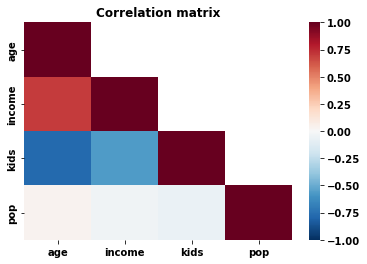

In [7]:
# check for intercorrelation between variables
%matplotlib inline

# helper function, replaces redundant values in correlation matrix with NaN
def maskRedundant(a):
    thisColIDX = 0
    for x in a.columns:
        a[x] = np.concatenate((np.array([np.nan] * thisColIDX), a[x][thisColIDX:]))
        thisColIDX += 1
    return a

# helper function to conduct & report pairwise contrasts
def printContrasts(df):
# get list of pairwise contrasts (tupel)
    featList = list(df.columns[1:])
    allContrasts = []
    for count, val in enumerate(featList[:-1]): 
        b = list(zip([val] * len(featList[count+1:]), featList[count+1:]))
        allContrasts.extend(b)        
# run pairwise contrasts
    for x in allContrasts:
        cc, p = pearsonr(df[x[0]], df[x[1]])
        theStr = 'significant = {:}, p = {:.3f} | r = {:.3f} | R = {:.3f}'.format(p < .05, p, cc, cc**2)
        print('CONTRAST {:} vs {:} \t | '.format(x[0], x[1]) + theStr)
    

# RUN 
selY = ['2018']                                                                           # year 
selC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']          # continents 

df = selectYEAR(selY)                            
df, contInfo = selectCONTINENT(df, selC)     
a = df.corr()
a = maskRedundant(a)
sns.heatmap(a, cmap = 'RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation matrix')
printContrasts(df)

__Life expectancy (age) and fertility (kids) are negatively correlated__, but they are also interrelated with the economic factor income; see heatmap and contrasts. These correlations do not imply causation. But it is striking how strongly life expectancy is linked with birth rate - fewer births are associated with longer lives!

Population size is not correlated with the variables of interest (which would be odd), so we have passed the sanity check.

Closer look at the association between fertility and life expectancy
ACROSS THE BOARD


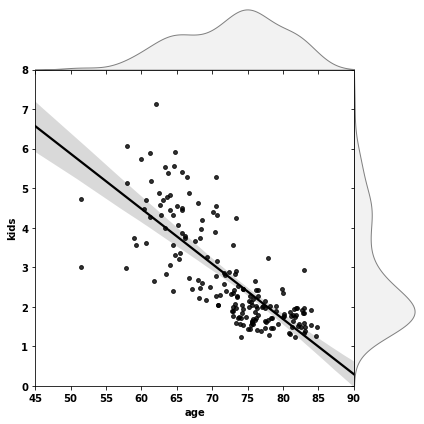


SEPARATELY PER CONTINENT


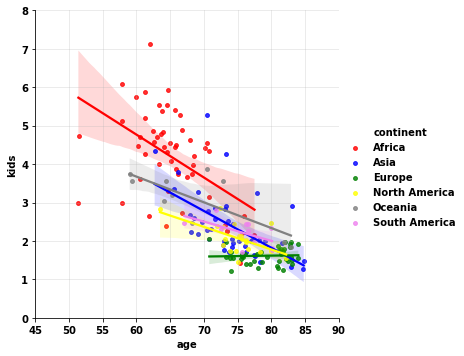

In [8]:
print('Closer look at the association between fertility and life expectancy\nACROSS THE BOARD')
g = sns.JointGrid(data=df, x='age', y='kids', xlim=(45, 90), ylim=(0, 8), space=0, height=6);
g.plot_joint(sns.regplot, line_kws={'color': 'black'}, scatter_kws={'color': 'black', 's': 15}, truncate=False)
g.plot_marginals(sns.kdeplot, fill=True, alpha=.1, color='gray');
plt.show();

print('\nSEPARATELY PER CONTINENT')
sns.lmplot(data=df, x='age', y='kids', hue = 'continent',palette = contInfo.colors.tolist(), scatter_kws={'s': 15}, height=5); 
plt.xlim(45,90)
plt.ylim(0,8)
plt.grid(alpha=.3)

# optional: decomment line below to see scatterplots between all pairs of relevant variables
#sns.pairplot(df[['age', 'income', 'kids', 'continent']], hue='continent', diag_kind='kde', palette = contInfo.colors.tolist());

The negative correlation between fertility & life expectancy can be seen for all continents except Europe (floor effect limiting variability in fertility?). 

---------------
__To observe how the variables life expectancy and fertility change over time, run the cell below__ (Feel free to change the time range and selected contintents). The sizes of data point markers index income. 

In [11]:
# run this cell for TIMECOURSE SCATTERPLOT
%matplotlib qt

# Change these constants to modify plot ===================================================================================
selY = ['1915', '2018']                # start year, end year 
selC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']          # continents to include
scale2feat = 'income'                  # variable indexes by marker size (no scaling if set to None) 
xAxFeat = 'age'                        # variable shown on X-axis
yAxFeat = 'kids'                       # variable shown on Y-axis
# (optional) ---------------------------------------------------------------------------------------------------------------
xAXSTR = 'Life Expectancy (years)'     # for now (may need to be changed if different feature is used for axis)
yAXSTR = 'Birth Rate (kids per woman)' # for now ...
# (do not change) ----------------------------------------------------------------------------------------------------------
tSTR = 'Timecourse ' + selY[0] + '-' + selY[1]
fontSMALL = 14
fontLARGE = 18
# ==========================================================================================================================

# get time range: convert list of strings (start / end year) to integers
selY = list(map(int, selY)) # convert to integers
selY = [str(x) for x in np.arange(selY[0],selY[1]+1)] 

def getAxLimits():
    def getRangeDFX(thisDF):
        tempo = cList.merge(thisDF[selY].agg([np.min, np.max], axis=1), how='inner', left_index=True, right_index=True, suffixes=('', '_y'))    
        tempo = tempo[tempo.continent.isin(selC)]
        return [np.floor(np.min(tempo.amin)), np.ceil(np.max(tempo.amax))]    
    # select the x- and y-axLimits:            
    checkList = ['pop', 'age', 'income', 'kids'] # security check - make sure only allowed vars are evaluated
    if (any(xAxFeat in s for s in checkList) & any(yAxFeat in s for s in checkList)):
        xAxLim = getRangeDFX(eval('d_' + xAxFeat))        
        yAxLim = getRangeDFX(eval('d_' + yAxFeat))
    else:
         print('BAD VARIABLE NAME - abort')
         xAxLim = np.nan; yAxLim = np.nan    
    return xAxLim, yAxLim


# animation function, fetches data and plots it per iteration
def plotFig(f):    
    df = select1YEAR(f)                         # get data for current year
    df, contInfo = selectCONTINENT(df, selC)   # get data for continent selection 
    plt.clf()
    cMap = matplotlib.colors.ListedColormap(contInfo['colors'])
    colours = contInfo['colors'][df.continent.astype('category').cat.codes]    
    scatter = sns.scatterplot(x=xAxFeat, y=yAxFeat, data=df, hue=colours.index, palette = contInfo.colors.tolist(), alpha=.7, edgecolors = 'white', size=scale2feat, sizes = (5,1000))    
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles=handles[:len(contInfo)], labels=labels[:len(contInfo)], fontsize = fontSMALL, loc=3)
    plt.xlabel(xAXSTR, fontsize = fontSMALL)
    plt.ylabel(yAXSTR, fontsize = fontSMALL)
    plt.title(str(f), fontsize = fontLARGE)
    scatter.spines['top'].set_visible(False)
    scatter.spines['right'].set_visible(False)
    scatter.set_xlim(xLims)
    scatter.set_ylim(yLims)
    plt.grid(alpha=.3)
    plt.draw()

# RUN
xLims, yLims = getAxLimits()
fig = plt.figure(figsize=(16,12))
myA = animation.FuncAnimation(fig, plotFig, frames=selY, interval=200, repeat = False)

-----------
__Snapshot__ Static scatterplot of age vs fertility at a given time. Click on the dots to get information about the country it represents. 
(Feel free to change the year or continent selection) 

In [12]:
# run this cell for INTERACTIVE (STATIC) SCATTERPLOT illustrating the association of three variables in a given year (snapshot)
%matplotlib qt

# Change these constants to modify plot ===================================================================================
selY = ['1939']                        # single year or multiple years | for a continuous range, use: selY = [str(x) for x in np.arange(1915,2015)]
selC = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']          # continents to include
scale2feat = 'income'                  # variable indexes by marker size (no scaling if set to None) 
xAxFeat = 'age'                        # variable shown on X-axis
yAxFeat = 'kids'                       # variable shown on Y-axis
# (optional) ---------------------------------------------------------------------------------------------------------------
xAXSTR = 'Life Expectancy (years)'     # for now (may need to be changed if different feature is used for axis)
yAXSTR = 'Birth Rate (kids per woman)' # for now ...
# (do not change) ----------------------------------------------------------------------------------------------------------
tSTR = 'Year: {}'.format('+'.join(selY))
fontSMALL = 14
fontLARGE = 18
# ==========================================================================================================================

# draw scatterplot with labels 
def plotFig():    
    cMap = matplotlib.colors.ListedColormap(contInfo['colors'])
    colours = contInfo['colors'][df.continent.astype('category').cat.codes]    
    scatter = sns.scatterplot(x=xAxFeat, y=yAxFeat, data=df, hue=colours.index, palette = contInfo.colors.tolist(), alpha=.7, edgecolors='white',picker=True, pickradius=1, size=scale2feat, sizes = (5,1000))    
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles=handles[:len(contInfo)], labels=labels[:len(contInfo)], fontsize = fontSMALL)
    plt.xlabel(xAXSTR, fontsize = fontSMALL)
    plt.ylabel(yAXSTR, fontsize = fontSMALL)
    plt.title(tSTR, fontsize = fontLARGE)
    scatter.spines['top'].set_visible(False)
    scatter.spines['right'].set_visible(False)
    plt.grid(alpha=.3)

# function adding interactivity: print stats for clicked country as annotation, then show figure  
def onclick(event):
    plt.clf()
    plotFig()
    ind = event.ind[0]
    thisStr = '{}\n{}m pop\n${}k income\n{} kids\n{}y life exp'.format(df.index[ind].upper(), np.round(df.iloc[ind]['pop']/1000000,2), np.round(df.iloc[ind]['income']/1000,1), np.round(df.iloc[ind]['kids'],1), np.round(df.iloc[ind]['age'],1))
    xd = df.iloc[ind][xAxFeat]+.5
    yd = df.iloc[ind][yAxFeat]
    plt.annotate(thisStr, xy=[xd, yd], ha='left', va='center', xycoords='data', bbox=dict(boxstyle='round', fc='1'), fontsize=fontSMALL) #, textcoords='offset points'    
    plt.draw()    
    
# RUN ---------------------------------------
df = selectYEAR(selY)                            # select time 
df, contInfo = selectCONTINENT(df, selC)     # select place
fig = plt.figure(figsize=(16,12))            # create figure and plot
plotFig()    
fig.canvas.mpl_connect('pick_event', onclick);

C:\Users\s01tk9\AppData\Local\Temp\ipykernel_25620\2258194155.py:80: FutureWarning: Passing 'suffixes' which cause duplicate columns {'mean_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(d_pop[selY].agg([np.mean], axis=1), how='inner', left_index=True, right_index=True)
